In [1]:
import cv2
import numpy as np
from typing import Tuple, List, Text, Dict, Any, Iterator
import time
from matplotlib import pyplot as plt
%matplotlib inline

/home/ubuntu/.pyenv/versions/anaconda3-4.2.0/lib/python3.5/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')
/home/ubuntu/.pyenv/versions/anaconda3-4.2.0/lib/python3.5/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [152]:
x = 'SegNet-Tutorial/CamVid/test/0001TP_008550.png'
y = 'SegNet-Tutorial/CamVid/testannot/0001TP_008550.png'
#x = 'SegNet-Tutorial/CamVid/train/0001TP_007140.png'
#y = 'SegNet-Tutorial/CamVid/trainannot/0001TP_007140.png'

img = cv2.imread(x)
mask = cv2.imread(y)
norm = np.zeros(img.shape, np.float32)
norm[:,:,0] = cv2.equalizeHist(img[:,:,0])
norm[:,:,1] = cv2.equalizeHist(img[:,:,1])
norm[:,:,2] = cv2.equalizeHist(img[:,:,2])
annot = np.zeros(mask.shape, np.float32)
for i in range(12): annot[np.where(mask == i)] = 255/12*i


In [153]:
import tensorflow as tf

use_indices = False

with tf.device('/cpu:0'):
    from keras.models import model_from_json
    if use_indices:
        with open('segnet_model.json', 'r') as f: model = model_from_json(f.read())
        model.load_weights('segnet_indecis_weight.hdf5')
    else:
        import SegNet
        model = SegNet.create_segnet(shape=(480, 360, 3), nb_class=12, indices=True)
        model.load_weights('segnet_weight.hdf5')
    frame = np.expand_dims(np.einsum('hwc->whc', norm), axis=0)
    output = model.predict(frame)

print(output.shape, output[0].shape)

output = np.einsum('whc->hwc', output[0])
output = np.argmax(output, axis=2)
_annot = np.zeros(annot.shape, np.float32)

for i in range(12): _annot[np.where(output == i)] = 255/12*i


(1, 480, 360, 12) (480, 360, 12)


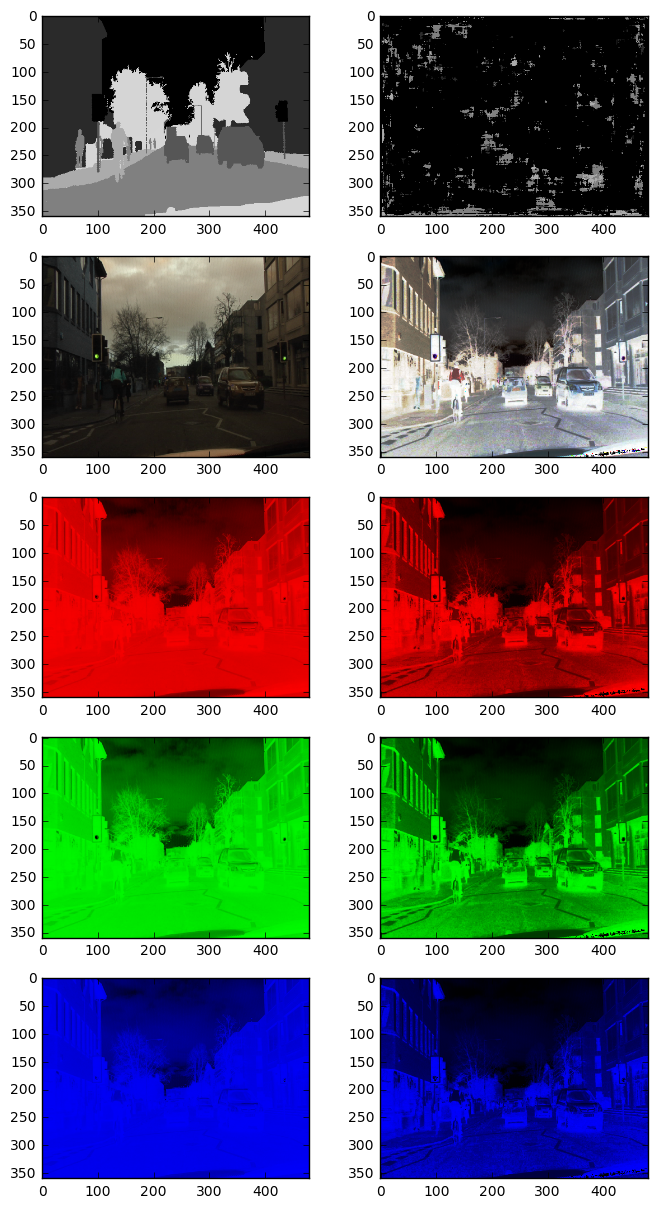

In [154]:

def mtx_plot(fnmtx, ratio):
    h = len(fnmtx[0])
    w = len(fnmtx)
    k = 1
    fig = plt.figure(figsize=(ratio[0]*h, ratio[1]*w))
    for fnarr in fnmtx:
        for fn in fnarr:
            fig.add_subplot(w,h,k)
            fn(k)
            k += 1

mat = [
    [
        lambda x: plt.imshow(annot),
        lambda x: plt.imshow(_annot),
    ],
    [
        lambda x: plt.imshow(img),
        lambda x: plt.imshow(norm),
    ]
]
for ch in range(3):
    mat.append([
        (lambda ch:
            (lambda x: exec('tmp = np.zeros(norm.shape, np.float32); tmp[:,:,%d] = img[:,:,%d]; plt.imshow(tmp)' % (ch, ch)))
        )(ch),
        (lambda ch:
            (lambda x: exec('tmp = np.zeros(norm.shape, np.float32); tmp[:,:,%d] = norm[:,:,%d]; plt.imshow(tmp)' % (ch, ch)))
        )(ch),
    ])

mtx_plot(mat, ratio=(4,3))


In [ ]:
valid_gen batch_gen_len